In [60]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

In [61]:
import sys
sys.path.append('../../../')

from src.predictor_util import modelfit
from src.plot_utils import plot_confusion_matrix, analysing_feature_importance
from src.transformer_utils import encode_labels, process_features_standardisation, one_hot_encode_field

## 1. Chargement du Dataset

In [62]:
df = pd.read_csv('../../../data/outputs/05_merged_data.csv')

In [63]:
df.shape
df.head()

,resultId,raceId,driverId,constructorId,grid,race_rank,points,laps,milliseconds,fastestLap,...,round,circuitId,circuit_name,constructor_name,country,constructor_is_active,nationality,driver_is_active,full_name,season_age
0,1,18,1,1,1,1,10.0,58,5690616,39,...,1,1,Australian Grand Prix,McLaren,British,1,British,1,Lewis Hamilton,23
1,2,18,2,2,5,2,8.0,58,5696094,41,...,1,1,Australian Grand Prix,BMW Sauber,German,0,German,0,Nick Heidfeld,31
2,3,18,3,3,7,3,6.0,58,5698779,41,...,1,1,Australian Grand Prix,Williams,British,1,German,0,Nico Rosberg,23
3,4,18,4,4,11,4,5.0,58,5707797,58,...,1,1,Australian Grand Prix,Renault,French,0,Spanish,1,Fernando Alonso,27
4,5,18,5,1,3,5,4.0,58,5708630,43,...,1,1,Australian Grand Prix,McLaren,British,1,Finnish,0,Heikki Kovalainen,27


## 2. Retirer les colonnes non importantes

In [64]:
# Selection des colonnes de types objets puis suppression car le modèle ne lit pas ce type de données
cols = df.select_dtypes(np.object_).columns.to_list()
# Les correlations avec la variable a prédire sont très faibles avec ces champs ci, donc ils sont à exclure
not_corr_cols = ['constructorId', 'driverId', 'raceId', 'resultId', 'year', 'round', 'circuitId', 'season_age']

# Associer toutes les colonnes ensembles
cols = cols + not_corr_cols
df = df.drop(cols, axis=1)

In [65]:
df.head()

,grid,race_rank,points,laps,milliseconds,fastestLap,fastestLapTime,fastestLapSpeed,statusId,constructor_is_active,driver_is_active
0,1,1,10.0,58,5690616,39,87452,218.300,1,1,1
1,5,2,8.0,58,5696094,41,87739,217.586,1,0,0
2,7,3,6.0,58,5698779,41,88090,216.719,1,1,0
3,11,4,5.0,58,5707797,58,88603,215.464,1,0,1
4,3,5,4.0,58,5708630,43,87418,218.385,1,1,0


## 3. Encodage des colonnes catégorielles

In [66]:
df = encode_labels(df, ['grid', 'race_rank', 'laps', 'fastestLap', 'statusId'])

## 4. Normalisation de certaines colonnes

In [67]:
cols = ['points', 'milliseconds', 'fastestLapTime', 'fastestLapSpeed']
df[cols] = process_features_standardisation(df, cols, StandardScaler)

In [68]:
df.head()

,grid,race_rank,points,laps,milliseconds,fastestLap,fastestLapTime,fastestLapSpeed,statusId,constructor_is_active,driver_is_active
0,1,0,1.918025,58,1.355755,38,-1.558652,1.705459,0,1,1
1,5,1,1.444051,58,1.357629,40,-1.558533,1.697797,0,0,0
2,7,2,0.970076,58,1.358548,40,-1.558387,1.688492,0,1,0
3,11,3,0.733088,58,1.361634,57,-1.558175,1.675024,0,0,1
4,3,4,0.496101,58,1.361919,42,-1.558666,1.706371,0,1,0


## 5. Entrainement du modèle

In [69]:
target = 'race_rank'
features = [x for x in df.columns if x not in [target]]

In [70]:
# Instantiation du modèle de classification
xgb_model = xgb.XGBClassifier(
    n_estimators=205,
    learning_rate=0.001,
    max_depth=120,
    eta= 0.18,
    subsample= .8,
    colsample_bytree= 0.8,
    objective= 'multi:softmax',
    eval_metric='merror',
    min_child_weight = 9,
    gamma = 0,
    n_jobs=-1,
    num_class= 25,
    enable_categorical=True,
    seed=80,
)

In [71]:
model = modelfit(df, features, target, xgb_model)


Model Report
Accuracy : 0.362
AUC Score (Train): 0.932414
AUC Score (Test): 0.914216


### 5.1. Rapport de classification

In [72]:
print("Classification Report:")
print(model[4])

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       318
           1       0.93      0.87      0.90       355
           2       0.92      0.90      0.91       332
           3       0.84      0.94      0.89       327
           4       0.89      0.86      0.88       330
           5       0.81      0.77      0.79       331
           6       0.34      0.58      0.43       313
           7       0.39      0.35      0.37       337
           8       0.37      0.32      0.34       323
           9       0.29      0.33      0.31       331
          10       0.15      0.24      0.19       323
          11       0.09      0.05      0.06       343
          12       0.12      0.08      0.09       339
          13       0.10      0.11      0.10       303
          14       0.11      0.11      0.11       314
          15       0.11      0.05      0.07       346
          16       0.09      0.09      0.09       313
    

### 5.2. Matrix de confusion

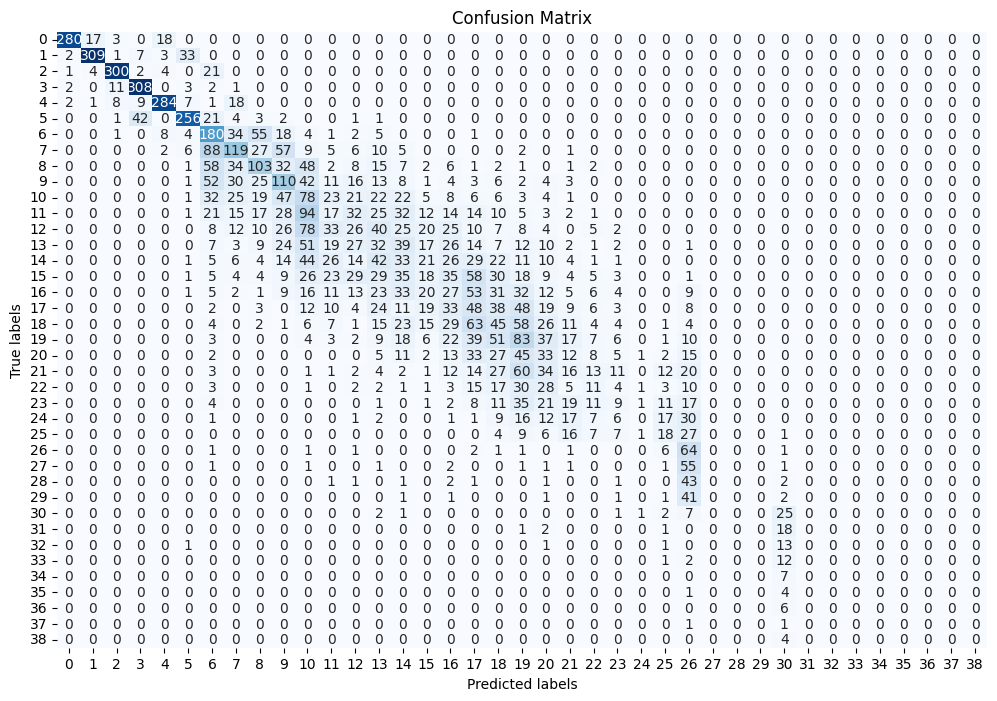

In [73]:
plot_confusion_matrix((model[1], model[2]))

### 5.3. Feature importance

In [74]:
feature_imp_serie = pd.Series(model[0].get_booster().get_fscore()).sort_values(ascending=False)
analysing_feature_importance(feature_imp_serie)

On remarque que la standardisation de certaines caractéristiques est sans effect sur le modèle.<br>
Procédons à l'encodage de la caractéristique grid (Position sur la grille de départ)

## 6. Entrainement du model 2 

### 6.1. Encodage binaire de la colonne categorielles

In [75]:
for field in ['grid', 'laps', 'statusId']:
    df = one_hot_encode_field(df, field)

In [76]:
df.head()

,race_rank,points,milliseconds,fastestLap,fastestLapTime,fastestLapSpeed,constructor_is_active,driver_is_active,grid_1,grid_2,...,statusId_127,statusId_128,statusId_129,statusId_130,statusId_131,statusId_132,statusId_133,statusId_134,statusId_135,statusId_136
0,0,1.918025,1.355755,38,-1.558652,1.705459,1,1,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.444051,1.357629,40,-1.558533,1.697797,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.970076,1.358548,40,-1.558387,1.688492,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.733088,1.361634,57,-1.558175,1.675024,0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.496101,1.361919,42,-1.558666,1.706371,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 6.2. Entrainement

In [77]:
target = 'race_rank'
features = [x for x in df.columns if x not in [target]]

In [78]:
# Utilisons le même modèle (avec les mêmes caractéristiques)
model2 = modelfit(df, features, target, xgb_model)


Model Report
Accuracy : 0.3496
AUC Score (Train): 0.907758
AUC Score (Test): 0.894828


### 6.3. Rapport de classification

In [79]:
print("Classification Report:")
print(model2[4])

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       318
           1       0.93      0.87      0.90       355
           2       0.92      0.90      0.91       332
           3       0.84      0.94      0.88       327
           4       0.89      0.86      0.87       330
           5       0.80      0.77      0.79       331
           6       0.35      0.61      0.45       313
           7       0.71      0.25      0.37       337
           8       0.39      0.30      0.34       323
           9       0.28      0.34      0.31       331
          10       0.18      0.16      0.17       323
          11       0.15      0.10      0.12       343
          12       0.14      0.07      0.10       339
          13       0.09      0.05      0.07       303
          14       0.06      0.11      0.08       314
          15       0.09      0.10      0.09       346
          16       0.07      0.08      0.07       313
    

### 6.4. Matrix de confusion

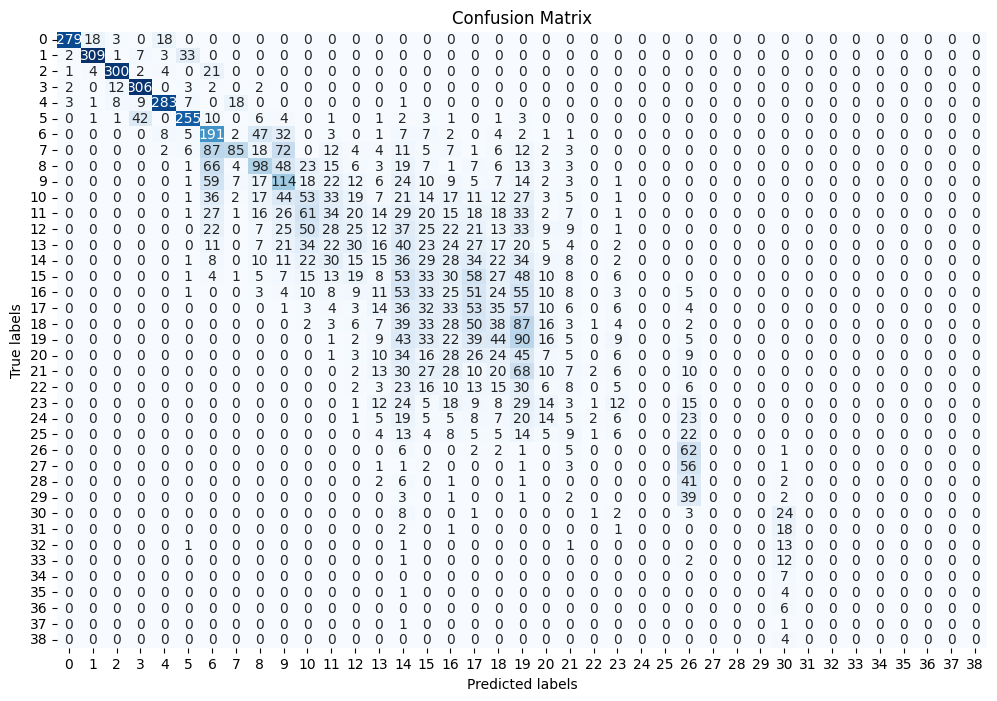

In [80]:
plot_confusion_matrix((model2[1], model2[2]))

### 6.5. Feature Importance

In [81]:
feature_imp_serie = pd.Series(model2[0].get_booster().get_fscore()).sort_values(ascending=False)
analysing_feature_importance(feature_imp_serie)

## Conclusion 

Au vue de la non amélioration des performaces du modèles, mais plutot à la détérioration de celle-ci procédons par la suite à l'ingénieurie des caractéristiques des pilotes et constructeurs pour améliorer les résultats<br>
```data_prep/08_feature_engineering.ipynb```